In [9]:
from qiskit import *

In [1]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error
# a simple noise model, which randomly flips each bit in an output with probability 𝑝.
def get_noise(p):

    error_meas = pauli_error([('X',p), ('I', 1 - p)])

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_meas, "measure") # measurement error is applied to measurements
        
    return noise_model


In [52]:
# case where each bit is flipped 1% of the time
noise_model = get_noise(0)

In [60]:
for state in ['00','01','10','11']:
    qr = QuantumRegister(2)
    cr = ClassicalRegister(2)
    qc = QuantumCircuit(qr, cr)
    if state[0]=='1':
        qc.x(qr[1])
    if state[1]=='1':
        qc.x(qr[0])  
    qc.measure(qc.qregs[0],qc.cregs[0])
    print(state+' becomes',
          execute(qc,Aer.get_backend('qasm_simulator'),noise_model=noise_model,shots=1000).result().get_counts())
    print(qc)

00 becomes {'00': 1000}
          ┌─┐   
q52_0: |0>┤M├───
          └╥┘┌─┐
q52_1: |0>─╫─┤M├
           ║ └╥┘
 c52_0: 0 ═╩══╬═
              ║ 
 c52_1: 0 ════╩═
                
01 becomes {'01': 1000}
          ┌───┐┌─┐
q53_0: |0>┤ X ├┤M├
          └┬─┬┘└╥┘
q53_1: |0>─┤M├──╫─
           └╥┘  ║ 
 c53_0: 0 ══╬═══╩═
            ║     
 c53_1: 0 ══╩═════
                  
10 becomes {'10': 1000}
               ┌─┐   
q54_0: |0>─────┤M├───
          ┌───┐└╥┘┌─┐
q54_1: |0>┤ X ├─╫─┤M├
          └───┘ ║ └╥┘
 c54_0: 0 ══════╩══╬═
                   ║ 
 c54_1: 0 ═════════╩═
                     
11 becomes {'11': 1000}
          ┌───┐┌─┐   
q55_0: |0>┤ X ├┤M├───
          ├───┤└╥┘┌─┐
q55_1: |0>┤ X ├─╫─┤M├
          └───┘ ║ └╥┘
 c55_0: 0 ══════╩══╬═
                   ║ 
 c55_1: 0 ═════════╩═
                     


In [50]:
qr = QuantumRegister(2)
cr = ClassicalRegister(2)
qc = QuantumCircuit(qr, cr)
qc.h(qr[0])
qc.cx(qr[0],qr[1])  
qc.measure(qc.qregs[0],qc.cregs[0])
print(execute(qc,Aer.get_backend('qasm_simulator'),noise_model=noise_model,shots=10000).result().get_counts())

{'11': 4828, '01': 87, '00': 4975, '10': 110}


In [53]:
for state in ['00','01','10','11']:
    qc = QuantumCircuit(2,2)
    qc.h(0)
    qc.cx(0,1)  
    qc.measure(qc.qregs[0],qc.cregs[0])
    print(state+' becomes',
    execute(qc,Aer.get_backend('qasm_simulator'),noise_model=noise_model,shots=10000).result().get_counts())


00 becomes {'11': 4997, '00': 5003}
01 becomes {'11': 4994, '00': 5006}
10 becomes {'11': 4965, '00': 5035}
11 becomes {'11': 4985, '00': 5015}


In [54]:
from qiskit.ignis.mitigation.measurement import (complete_meas_cal,CompleteMeasFitter)

In [55]:
qr = qiskit.QuantumRegister(2)
meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')

In [58]:
for circuit in meas_calibs:
    print('Circuit',circuit.name)
    print(circuit)
    print()

Circuit mcalcal_00
           ░ ┌─┐   
q47_0: |0>─░─┤M├───
           ░ └╥┘┌─┐
q47_1: |0>─░──╫─┤M├
           ░  ║ └╥┘
 c47_0: 0 ════╩══╬═
                 ║ 
 c47_1: 0 ═══════╩═
                   

Circuit mcalcal_01
          ┌───┐ ░ ┌─┐   
q47_0: |0>┤ X ├─░─┤M├───
          └───┘ ░ └╥┘┌─┐
q47_1: |0>──────░──╫─┤M├
                ░  ║ └╥┘
 c47_0: 0 ═════════╩══╬═
                      ║ 
 c47_1: 0 ════════════╩═
                        

Circuit mcalcal_10
                ░ ┌─┐   
q47_0: |0>──────░─┤M├───
          ┌───┐ ░ └╥┘┌─┐
q47_1: |0>┤ X ├─░──╫─┤M├
          └───┘ ░  ║ └╥┘
 c47_0: 0 ═════════╩══╬═
                      ║ 
 c47_1: 0 ════════════╩═
                        

Circuit mcalcal_11
          ┌───┐ ░ ┌─┐   
q47_0: |0>┤ X ├─░─┤M├───
          ├───┤ ░ └╥┘┌─┐
q47_1: |0>┤ X ├─░──╫─┤M├
          └───┘ ░  ║ └╥┘
 c47_0: 0 ═════════╩══╬═
                      ║ 
 c47_1: 0 ════════════╩═
                        



In [61]:
# Execute the calibration circuits without noise
backend = qiskit.Aer.get_backend('qasm_simulator')
job = qiskit.execute(meas_calibs, backend=backend, shots=1000)
cal_results = job.result()

In [62]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
print(meas_fitter.cal_matrix)


[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


In [64]:
noise_model = get_noise(0.1)

In [65]:
backend = qiskit.Aer.get_backend('qasm_simulator')
job = qiskit.execute(meas_calibs, backend=backend, shots=1000, noise_model=noise_model)
cal_results = job.result()

meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
print(meas_fitter.cal_matrix)

[[0.806 0.076 0.088 0.011]
 [0.088 0.818 0.007 0.085]
 [0.095 0.014 0.813 0.093]
 [0.011 0.092 0.092 0.811]]


In [67]:
qc = QuantumCircuit(2,2)
qc.h(0)
qc.cx(0,1)  
qc.measure(qc.qregs[0],qc.cregs[0])

results = qiskit.execute(qc, backend=backend, shots=10000, noise_model=noise_model).result()

noisy_counts = results.get_counts()
print(noisy_counts)

{'11': 4075, '01': 912, '00': 4110, '10': 903}


In [68]:
# Get the filter object
meas_filter = meas_fitter.filter

# Results with mitigation
mitigated_results = meas_filter.apply(results)
mitigated_counts = mitigated_results.get_counts(0)

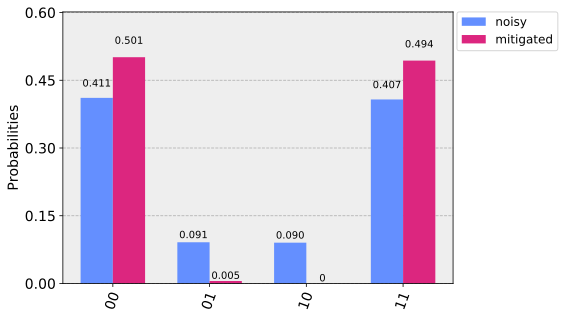

In [69]:
from qiskit.visualization import *
%config InlineBackend.figure_format = 'svg' # Makes the images look nice
plot_histogram([noisy_counts, mitigated_counts], legend=['noisy', 'mitigated'])

In [71]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.10.0',
 'qiskit-aer': '0.3.2',
 'qiskit-ignis': '0.2.0',
 'qiskit-ibmq-provider': '0.3.3',
 'qiskit-aqua': '0.6.1',
 'qiskit': '0.13.0'}